In [2]:
import netCDF4
import numpy
import matplotlib.pyplot as mp
import matplotlib.cm as cm
import time
import gdal
import gdalconst
import struct
import os
import datetime
import cartopy

#mp.rcParams.update({'mathtext.default': 'regular'})


%matplotlib inline

# BilFile functions

From http://stackoverflow.com/questions/23816545/reading-zipped-esri-bil-files-with-python

In [3]:
class BilFile(object):

    def __init__(self, bil_file):
        self.bil_file = bil_file
        self.hdr_file = bil_file.split('.')[0]+'.hdr'

    def get_array(self, mask=None):
        self.nodatavalue, self.data = None, None
        gdal.GetDriverByName('EHdr').Register()
        img = gdal.Open(self.bil_file, gdalconst.GA_ReadOnly)
        band = img.GetRasterBand(1)
        self.nodatavalue = band.GetNoDataValue()
        self.ncol = img.RasterXSize
        self.nrow = img.RasterYSize
        geotransform = img.GetGeoTransform()
        self.originX = geotransform[0]
        self.originY = geotransform[3]
        self.pixelWidth = geotransform[1]
        self.pixelHeight = geotransform[5]
        #print(self.pixelWidth, self.pixelHeight)
        #print(self.originX, self.originY)
        self.data = band.ReadAsArray()
        self.data = numpy.ma.masked_where(self.data==self.nodatavalue, self.data)
        if mask is not None:
            self.data = numpy.ma.masked_where(mask==True, self.data)
        return self.nodatavalue, self.data, self.originX, self.originY, self.pixelWidth, self.pixelHeight, self.nrow, self.ncol

unzip data

!unzip /Users/baird/Downloads/PRISM_ppt_stable_4kmM2_189501_198012_bil.zip -d /Users/baird/Downloads/PRISM_ppt_stable_4kmM2_189501_198012_bila

In [5]:
file_root = '/Users/baird/Downloads/PRISM_ppt_stable_4kmM2_189501_198012_bil'

In [6]:
dir_names = numpy.array(([str(i) for i in range(1895,1981)]))
print(dir_names.size)
print(dir_names)

86
['1895' '1896' '1897' '1898' '1899' '1900' '1901' '1902' '1903' '1904'
 '1905' '1906' '1907' '1908' '1909' '1910' '1911' '1912' '1913' '1914'
 '1915' '1916' '1917' '1918' '1919' '1920' '1921' '1922' '1923' '1924'
 '1925' '1926' '1927' '1928' '1929' '1930' '1931' '1932' '1933' '1934'
 '1935' '1936' '1937' '1938' '1939' '1940' '1941' '1942' '1943' '1944'
 '1945' '1946' '1947' '1948' '1949' '1950' '1951' '1952' '1953' '1954'
 '1955' '1956' '1957' '1958' '1959' '1960' '1961' '1962' '1963' '1964'
 '1965' '1966' '1967' '1968' '1969' '1970' '1971' '1972' '1973' '1974'
 '1975' '1976' '1977' '1978' '1979' '1980']


# Concatenate all data

In [22]:
nlat, nlon = 621, 1405
data_array_stack = numpy.empty((0,nlat,nlon))
data_array = numpy.zeros((0,nlat,nlon))
date_strings_stack = numpy.empty((0))
dates_stack = numpy.empty((0))

for i in range(1):#dir_names.size):
    
    data_array_stack = numpy.empty((0,nlat,nlon))
    data_array = numpy.zeros((0,nlat,nlon))
    date_strings_stack = numpy.empty((0))
    dates_stack = numpy.empty((0))
    
    print(dir_names[i])
    dir_index = i
    bil_dir = dir_names[dir_index]
    year = bil_dir
    if bil_dir=='2017':  nmonths=3
    else:  nmonths=12

    for month in range(nmonths):
        
        date = datetime.datetime(int(year),month+1,15)
        date_string = year+'{:02}'.format(month+1)
        date_strings_stack = numpy.hstack((date_strings_stack, date_string))
        print('/PRISM_ppt_stable_4kmM2_'+date_string+'_bil.bil')
        data_array = numpy.zeros((1, nlat, nlon))
        #print(date)

        if date.year<=1980:
            bilfile = BilFile(file_root+'/PRISM_ppt_stable_4kmM2_'+date_string+'_bil.bil')
        #elif ((date.year==2016)&(date.month in [8,10,11,12]) or (date.year==2017)):
        #    bilfile = BilFile(file_root+dir_names[dir_index]+'/PRISM_ppt_provisional_4kmM3_'+date_string+'_bil.bil')
        #else:
        #    bilfile = BilFile(file_root+dir_names[dir_index]+'/PRISM_ppt_stable_4kmM3_'+date_string+'_bil.bil')
            
        no_data_value, data, originX, originY, pixelWidth, pixelHeight, nrow, ncol = bilfile.get_array()

        originX_degE = originX+360.
        prism_lons = numpy.arange(originX_degE, originX_degE+(ncol-1)*pixelWidth+pixelWidth, pixelWidth)
        prism_lats = numpy.arange(originY, originY+(nrow-1)*pixelHeight+pixelHeight, pixelHeight)[::-1]
        data_array[0,:,:] = data[::-1,:]
        data_array[data_array==-9999]=numpy.nan

        data_array_stack = numpy.vstack((data_array_stack, data_array))
        dates_stack = numpy.hstack((dates_stack, date))

    #print(data_array_stack.shape)      

    # save data
    filename = './PRISM_ppt_stable_4kmD2_'+date_strings_stack[0]+'_'+date_strings_stack[-1]+'.nc'
    if os.path.exists(filename):
        os.remove(filename)
    ncfile = netCDF4.Dataset(filename, 'w', format='NETCDF4')
    time_dim = ncfile.createDimension('time', None) # None does unlimited dimension
    lat = ncfile.createDimension('lat', nlat)
    lon = ncfile.createDimension('lon', nlon)
    time_var = ncfile.createVariable('time', 'f4', ('time',))
    lats = ncfile.createVariable('lat', 'f4', ('lat',))
    lons = ncfile.createVariable('lon', 'f4', ('lon',))
    pr_data = ncfile.createVariable('pr', 'f4', ('time','lat','lon'), fill_value=numpy.nan)

    times_date2num = netCDF4.date2num(dates_stack, units='days since 1981-01-01', calendar='standard')

    time_var[:] = times_date2num
    lats[:] = prism_lats
    lons[:] = prism_lons
    pr_data[:] = data_array_stack
    time_var.units = 'days since 1981-01-01'
    lats.units = 'degrees_north'
    lons.units = 'degrees_east'
    pr_data.units = 'mm day-1'

    ncfile.history = 'Created ' + time.ctime(time.time())
    ncfile.close()
    print(filename, "saved")

1895
/PRISM_ppt_stable_4kmM2_189501_bil.bil
/PRISM_ppt_stable_4kmM2_189502_bil.bil
/PRISM_ppt_stable_4kmM2_189503_bil.bil
/PRISM_ppt_stable_4kmM2_189504_bil.bil
/PRISM_ppt_stable_4kmM2_189505_bil.bil
/PRISM_ppt_stable_4kmM2_189506_bil.bil
/PRISM_ppt_stable_4kmM2_189507_bil.bil
/PRISM_ppt_stable_4kmM2_189508_bil.bil
/PRISM_ppt_stable_4kmM2_189509_bil.bil
/PRISM_ppt_stable_4kmM2_189510_bil.bil
/PRISM_ppt_stable_4kmM2_189511_bil.bil
/PRISM_ppt_stable_4kmM2_189512_bil.bil
('./PRISM_ppt_stable_4kmD2_189501_189512.nc', 'saved')


# Concatenate all 2017 data

In [24]:
print(data.shape)
print(originX,originY)

(621, 1405)
(-125.02083333333333, 49.93750000000203)


In [68]:
# calculate mean
data_mean = numpy.nanmean(data_array, axis=0)

/Users/baird/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


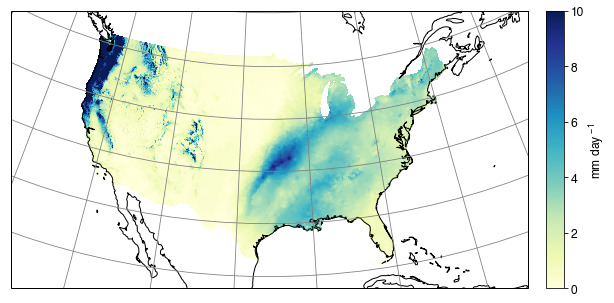

In [90]:
fontsize = 16
fig_width = 8.5

map_crs = cartopy.crs.LambertConformal(central_longitude=0.5*(prism_lons[-1]+prism_lons[0]), \
                                       central_latitude=0.5*(prism_lats[-1]+prism_lats[0]), \
                                       standard_parallels=(prism_lats.min(),prism_lats.max()))
data_crs = cartopy.crs.PlateCarree()

fontsize=12
contour_levels = numpy.arange(0,5.1,0.5)

fig = mp.figure(figsize=(8.,4.25))

ax = fig.add_subplot(111, projection=map_crs)

ax.coastlines('50m')
ax.gridlines(color='0.5', linestyle='-')

prism_map = ax.pcolormesh(prism_lons, \
                          prism_lats, \
                          data_mean/(365/12), \
                          transform=data_crs, \
                          vmin=0, \
                          vmax=10, \
                          cmap='YlGnBu')

# must go after axis creation and after tight_layout
# ax_extent = ax.get_window_extent()
# ax_extent_ratio = (ax_extent.y1-ax_extent.y0)/(ax_extent.x1-ax_extent.x0)
# fig.set_size_inches(fig_width, fig_width*ax_extent_ratio)

fig.tight_layout()

ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1, ax_pos.y0, 0.03, ax_pos.height])
cbar = mp.colorbar(prism_map, cax=cbar_ax)
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)